In [1]:
import sys
import os
sys.path.append(os.path.abspath("/data2/eranario/scratch/rgb-to-multispectral-unet"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from src.dataset import PotatoDataset
from src.model import UNet
# from src.util import show_predictions
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
# set torch random seed
torch.manual_seed(42)

# Dataset

In [4]:
rgb_dir = "/data2/eranario/data/Multispectral-Potato/Dataset/RGB_Images"
spectral_dir = "/data2/eranario/data/Multispectral-Potato/Dataset/Spectral_Images"

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

In [6]:
train_dataset = PotatoDataset(rgb_dir, spectral_dir, transform=transform, mode='train', align=True)
val_dataset = PotatoDataset(rgb_dir, spectral_dir, transform=transform, mode='val', align=True)
test_dataset = PotatoDataset(rgb_dir, spectral_dir, transform=transform, mode='test', align=True)

# print the size of the datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Loading test data: 100%|██████████| 60/60 [00:27<00:00,  2.22it/s]

Train dataset size: 240
Validation dataset size: 60
Test dataset size: 60


In [7]:
batch_size = 32
num_workers = 4

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers
)

# Model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=len(train_dataset.channels)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

In [9]:
from skimage.metrics import structural_similarity as ssim
from IPython.display import clear_output
import numpy as np
import time

def evaluateEuclideanDistance(predictedImage, groundTruthImage):
    # Compute Euclidean distance between pixels
    pixelDifferences = np.sqrt(np.sum((predictedImage - groundTruthImage) ** 2, axis=-1))
    # Compute the average Euclidean distance for the image
    averagePixelDifferences = np.mean(pixelDifferences)
    return averagePixelDifferences

num_epochs = 100
train_losses = []
val_losses = []
train_similarities = []  # SSIM for training
val_similarities = []    # SSIM for validation
train_euclidean_distances = []  # Euclidean distances for training
val_euclidean_distances = []    # Euclidean distances for validation

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_similarity_score = 0.0
    train_euclidean_distance_score = 0.0
    train_loop = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training", leave=True)

    for batch in train_loop:
        rgb_images, *spectral_images = batch
        rgb_images = rgb_images.to(device)  # Input images
        spectral_images = torch.stack(spectral_images, dim=1).squeeze(2).to(device)  # Target spectral channels

        # Forward pass
        optimizer.zero_grad()
        outputs = model(rgb_images)
        
        # Compute loss
        loss = criterion(outputs, spectral_images)
        loss.backward()
        optimizer.step()

        # Update progress
        train_loss += loss.item()

        # Compute SSIM and Euclidean distance for training
        for i in range(outputs.size(0)):  # Iterate over the batch size
            output_img = outputs[i].cpu().detach().numpy()  # Predicted image
            groundtruth_img = spectral_images[i].cpu().detach().numpy()  # Ground truth image

            # Normalize images to [0, 1] for SSIM computation
            output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min() + 1e-8)
            groundtruth_img = (groundtruth_img - groundtruth_img.min()) / (groundtruth_img.max() - groundtruth_img.min() + 1e-8)

            # Compute SSIM for each spectral band separately
            band_ssim = [
                ssim(output_img[band], groundtruth_img[band], data_range=1.0)
                for band in range(output_img.shape[0])
            ]
            train_similarity_score += np.mean(band_ssim)

            # Compute Euclidean distance for each spectral band
            band_euclidean_distance = [
                evaluateEuclideanDistance(output_img[band], groundtruth_img[band])
                for band in range(output_img.shape[0])
            ]
            train_euclidean_distance_score += np.mean(band_euclidean_distance)

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_similarity = train_similarity_score / len(train_dataloader.dataset)
    avg_train_euclidean_distance = train_euclidean_distance_score / len(train_dataloader.dataset)

    train_losses.append(avg_train_loss)
    train_similarities.append(avg_train_similarity)
    train_euclidean_distances.append(avg_train_euclidean_distance)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_similarity_score = 0.0
    val_euclidean_distance_score = 0.0
    val_loop = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation", leave=True)

    with torch.no_grad():
        for batch in val_loop:
            rgb_images, *spectral_images = batch
            rgb_images = rgb_images.to(device)
            spectral_images = torch.stack(spectral_images, dim=1).squeeze(2).to(device)

            outputs = model(rgb_images)
            loss = criterion(outputs, spectral_images)

            val_loss += loss.item()

            # Compute SSIM and Euclidean distance for validation
            for i in range(outputs.size(0)):
                output_img = outputs[i].cpu().numpy()
                groundtruth_img = spectral_images[i].cpu().numpy()

                # Normalize images to [0, 1]
                output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min() + 1e-8)
                groundtruth_img = (groundtruth_img - groundtruth_img.min()) / (groundtruth_img.max() - groundtruth_img.min() + 1e-8)

                # Compute SSIM for each spectral band separately
                band_ssim = [
                    ssim(output_img[band], groundtruth_img[band], data_range=1.0)
                    for band in range(output_img.shape[0])
                ]
                val_similarity_score += np.mean(band_ssim)

                # Compute Euclidean distance for each spectral band
                band_euclidean_distance = [
                    evaluateEuclideanDistance(output_img[band], groundtruth_img[band])
                    for band in range(output_img.shape[0])
                ]
                val_euclidean_distance_score += np.mean(band_euclidean_distance)

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_similarity = val_similarity_score / len(val_dataloader.dataset)
    avg_val_euclidean_distance = val_euclidean_distance_score / len(val_dataloader.dataset)

    val_losses.append(avg_val_loss)
    val_similarities.append(avg_val_similarity)
    val_euclidean_distances.append(avg_val_euclidean_distance)

    # Log results
    clear_output(wait=True)
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    print(f"  Train SSIM: {avg_train_similarity:.4f}, Val SSIM: {avg_val_similarity:.4f}")
    print(f"  Train Euclidean: {avg_train_euclidean_distance:.4f}, Val Euclidean: {avg_val_euclidean_distance:.4f}")
    time.sleep(1)

Epoch [100/100]
  Training Loss: 0.0096, Validation Loss: 0.0120
  Train SSIM: 0.6767, Val SSIM: 0.6758
  Train Euclidean: 1.3828, Val Euclidean: 1.4469


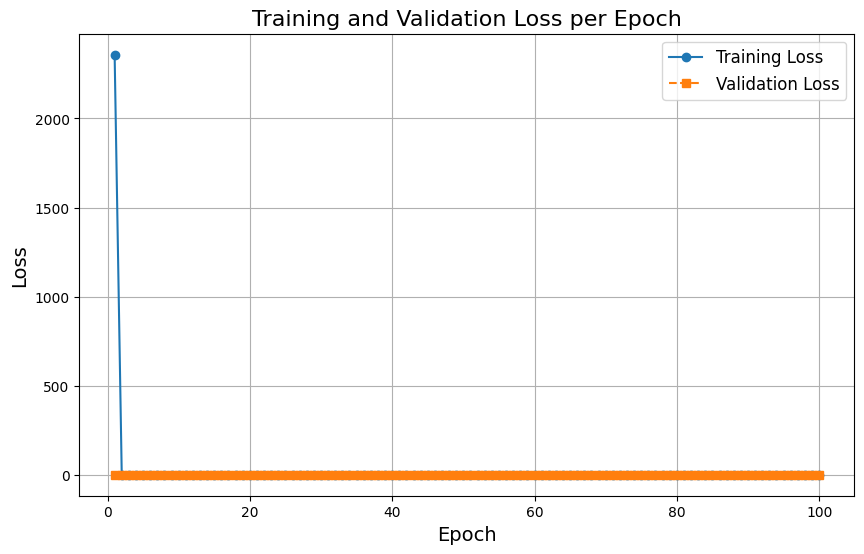

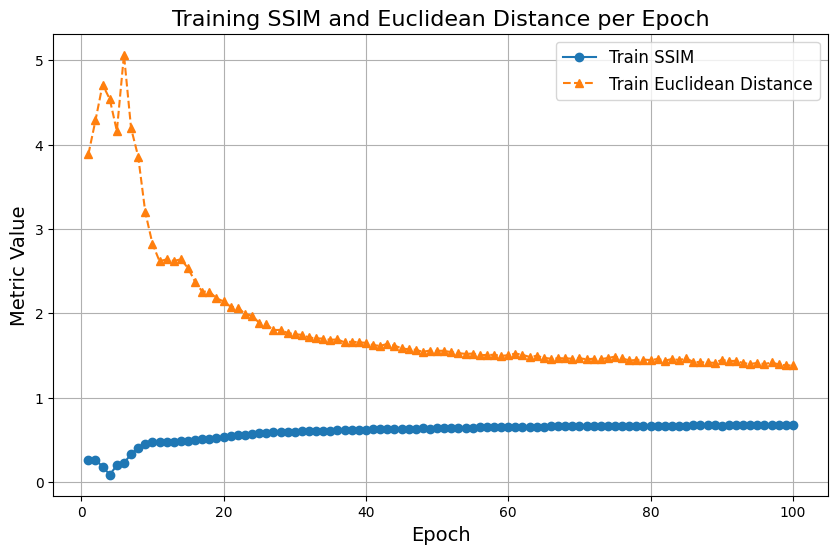

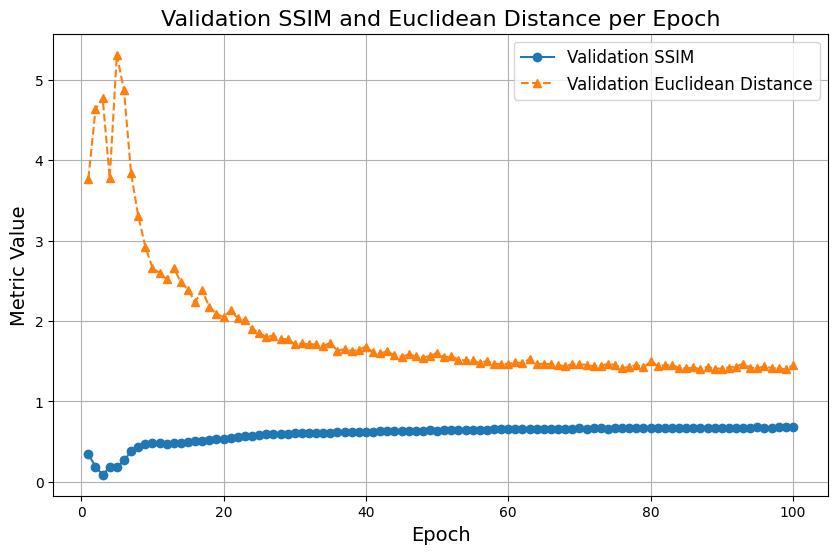

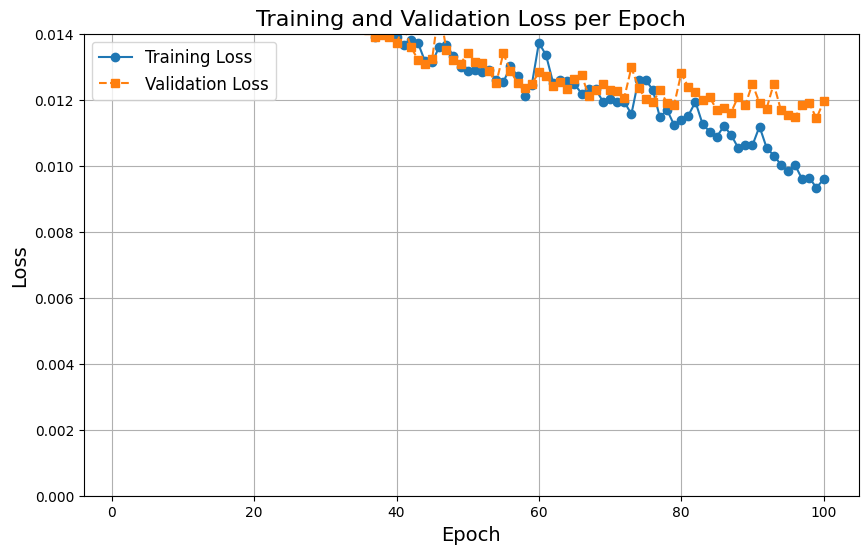

In [10]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', linestyle='--', label="Validation Loss")
plt.title("Training and Validation Loss per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Plotting SSIM and Euclidean Distance for Training
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_similarities, marker='o', linestyle='-', label="Train SSIM")
plt.plot(range(1, num_epochs + 1), train_euclidean_distances, marker='^', linestyle='--', label="Train Euclidean Distance")
plt.title("Training SSIM and Euclidean Distance per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Plotting SSIM and Euclidean Distance for Validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_similarities, marker='o', linestyle='-', label="Validation SSIM")
plt.plot(range(1, num_epochs + 1), val_euclidean_distances, marker='^', linestyle='--', label="Validation Euclidean Distance")
plt.title("Validation SSIM and Euclidean Distance per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


# Plotting training and validation loss curves with zoomed y-axis
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', linestyle='--', label="Validation Loss")
plt.title("Training and Validation Loss per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)

# Adjust y-axis limits to zoom in
min_loss = min(min(train_losses), min(val_losses))
plt.ylim(0, min_loss * 1.5)  # Set upper limit slightly above the minimum loss for better visibility

plt.show()

In [13]:
# Test phase
model.eval()
test_loss = 0.0
test_similarity_score = 0.0
test_euclidean_distance_score = 0.0

test_loop = tqdm(test_dataloader, desc="Testing", leave=True)

with torch.no_grad():
    for batch in test_loop:
        rgb_images, *spectral_images = batch
        rgb_images = rgb_images.to(device)  # Input images
        spectral_images = torch.stack(spectral_images, dim=1).squeeze(2).to(device)  # Target spectral channels

        outputs = model(rgb_images)
        loss = criterion(outputs, spectral_images)

        test_loss += loss.item()

        # Compute SSIM and Euclidean distance for the test set
        for i in range(outputs.size(0)):  # Iterate over the batch size
            output_img = outputs[i].cpu().numpy()  # Predicted image
            groundtruth_img = spectral_images[i].cpu().numpy()  # Ground truth image

            # Normalize images to [0, 1] for SSIM computation
            output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min() + 1e-8)
            groundtruth_img = (groundtruth_img - groundtruth_img.min()) / (groundtruth_img.max() - groundtruth_img.min() + 1e-8)

            # Compute SSIM for each spectral band separately
            band_ssim = [
                ssim(output_img[band], groundtruth_img[band], data_range=1.0)
                for band in range(output_img.shape[0])
            ]
            test_similarity_score += np.mean(band_ssim)

            # Compute Euclidean distance for each spectral band
            band_euclidean_distance = [
                evaluateEuclideanDistance(output_img[band], groundtruth_img[band])
                for band in range(output_img.shape[0])
            ]
            test_euclidean_distance_score += np.mean(band_euclidean_distance)

avg_test_loss = test_loss / len(test_dataloader)
avg_test_similarity = test_similarity_score / len(test_dataloader.dataset)
avg_test_euclidean_distance = test_euclidean_distance_score / len(test_dataloader.dataset)

# Log test results
print("\nTest Results:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test SSIM: {avg_test_similarity:.4f}")
print(f"  Test Euclidean Distance: {avg_test_euclidean_distance:.4f}")

Testing: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Test Results:
  Test Loss: 0.0127
  Test SSIM: 0.6422
  Test Euclidean Distance: 1.5178


In [11]:
def show_predictions(dataloader, model, device, channels=None):
    """
    Displays the RGB input, ground truth spectral channels, and model predictions for a single sample in a vertical layout.
    Args:
        dataloader: DataLoader to fetch data.
        model: Trained model to generate predictions.
        device: Device (CPU/GPU) to use.
        channels: List of channel names (e.g., ['Green', 'NIR', 'Red', 'Red Edge']).
    """
    model.eval()  # Set model to evaluation mode

    channels = channels or ['Green', 'NIR', 'Red', 'Red Edge']  # Default channel names
    num_spectral_channels = len(channels)

    # Get one batch of data
    rgb_images, *spectral_images = next(iter(dataloader))
    rgb_images = rgb_images.to(device)  # Move RGB inputs to the device
    spectral_images = torch.stack(spectral_images, dim=1).squeeze(2).to(device)  # Ground truth
    predictions = model(rgb_images)  # Model predictions

    # Use only the first sample in the batch
    rgb_image = rgb_images[1].permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC for RGB
    ground_truth = spectral_images[1].cpu().numpy()  # (num_channels, H, W)
    prediction = predictions[1].detach().cpu().numpy()  # Detach, then convert to NumPy (num_channels, H, W)

    # Create a vertical layout figure
    fig, axs = plt.subplots(num_spectral_channels, 3, figsize=(15, 5 * num_spectral_channels))
    for channel_idx in range(num_spectral_channels):
        spectral_channel_gt = ground_truth[channel_idx]  # Ground truth for this channel
        spectral_channel_pred = prediction[channel_idx]  # Prediction for this channel

        # RGB input
        if channel_idx == 0:  # Show RGB only in the first row
            axs[channel_idx, 0].imshow(rgb_image)
            axs[channel_idx, 0].set_title("RGB Input")
        else:
            axs[channel_idx, 0].axis("off")  # Keep empty for other rows

        # Ground truth
        axs[channel_idx, 1].imshow(spectral_channel_gt, cmap="viridis")
        axs[channel_idx, 1].set_title(f"GT: {channels[channel_idx]}")

        # Prediction
        axs[channel_idx, 2].imshow(spectral_channel_pred, cmap="viridis")
        axs[channel_idx, 2].set_title(f"Pred: {channels[channel_idx]}")

        # Remove axes for cleaner visualization
        axs[channel_idx, 0].axis("off")
        axs[channel_idx, 1].axis("off")
        axs[channel_idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

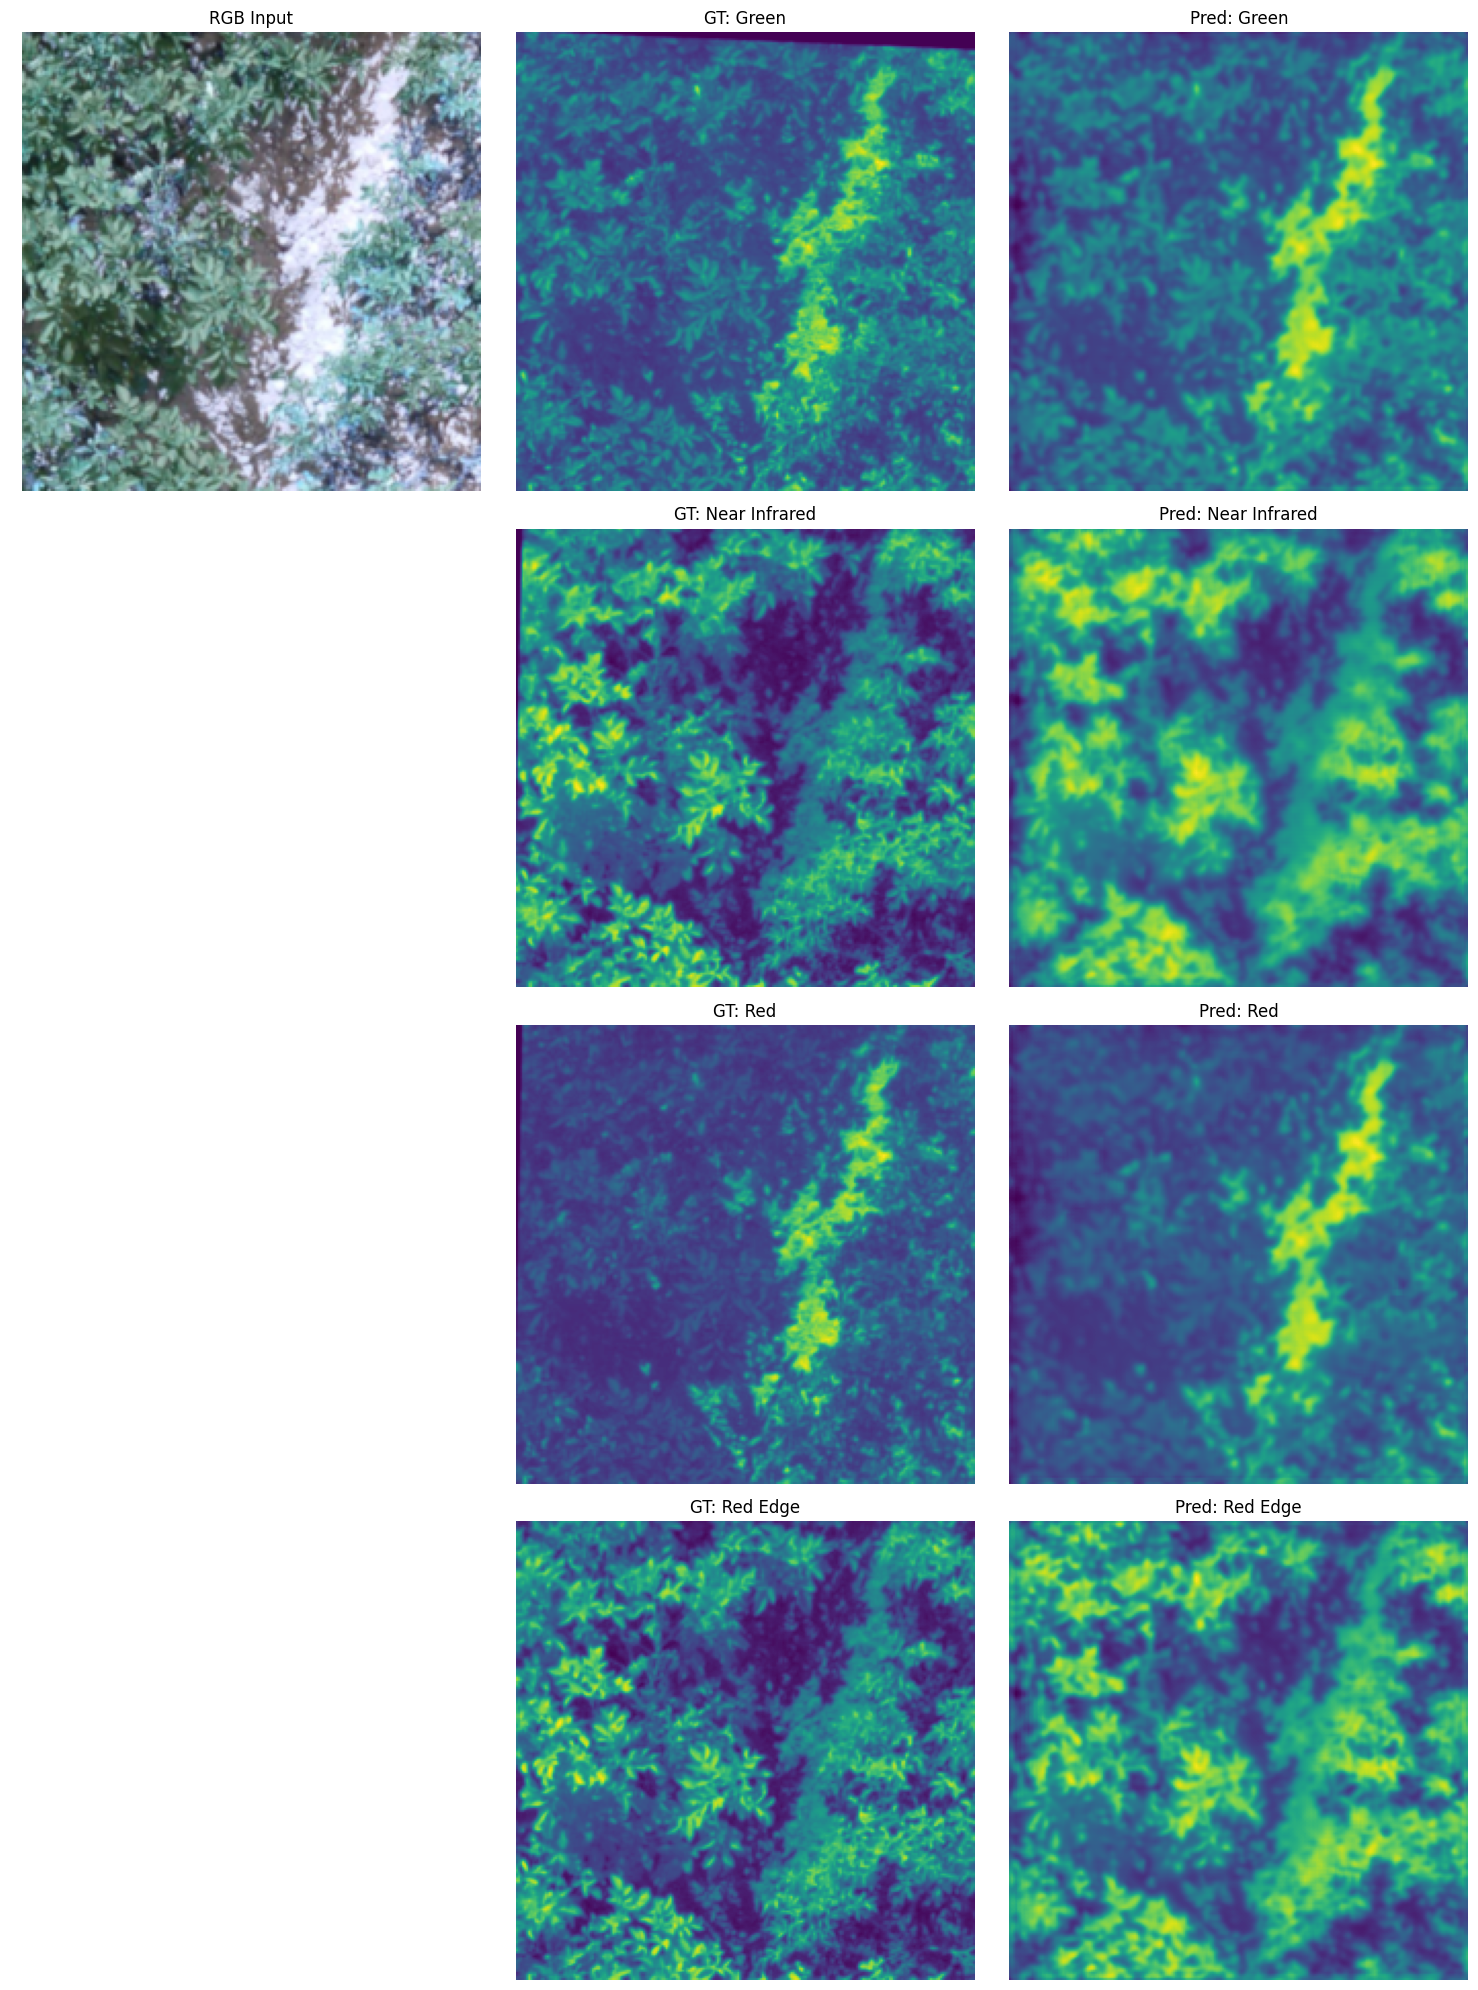

In [12]:
channels = ['Green', 'Near Infrared', 'Red', 'Red Edge']
show_predictions(test_dataloader, model, device, channels=channels)